Deep classification on Fashion-MNIST using pytorch

pierre-henri.conze@imt-atlantique.fr 

francois.rousseau@imt-atlantique.fr 


---



#### **Student name** :   ZHAN NING


### Objective of this lab session: perform classification on Fashion-MNIST using multi-layer perceptron, convolutional neural networks and transfer learning to obtain the best classification results as possible.

#### Challenge: the first 3 students in terms of overall test accuracy results (whatever the methodology used) will obtain bonus points!

### Table of Contents

* [Data management](#section_1)
    * [Question 1.1](#question_1_1)
    * [Question 1.2](#question_1_2)
    * [Question 1.3](#question_1_3)
    * [Question 1.4](#question_1_4)
* [Multi-Layer Perceptron](#section_2)    
    * [Question 2.1](#question_2_1)
    * [Question 2.2](#question_2_2)
    * [Question 2.3](#question_2_3)
    * [Question 2.4](#question_2_4)
    * [Question 2.5](#question_2_5)
* [Convolutional neural network](#section_3)    
    * [Question 3.1](#question_3_1)
    * [Question 3.2](#question_3_2)
    * [Question 3.3](#question_3_3)
    * [Question 3.4](#question_3_4)
    * [Question 3.5](#question_3_5)
    * [Question 3.6](#question_3_6)
    * [Question 3.7](#question_3_7)
* [Transfer learning from ImageNet](#section_4)    
    * [Question 4.1](#question_4_1)
    * [Question 4.2](#question_4_2)
    * [Question 4.3](#question_4_3)
    * [Question 4.4](#question_4_4)
    * [Question 4.5](#question_4_5)
* [Challenge](#section_5)    
    * [Question 5.1](#question_5_1)

## 1- Data management <a class="anchor" id="section_1"></a>

Start with these lines of code to automatically download the Fashion-MNIST dataset.

In [1]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

ModuleNotFoundError: No module named 'torchvision'

#### **Question 1.1** - Fashion-MNIST is a dataset consisting of a training set of A examples and a test set of B examples. Each example is a CxC grayscale image, associated with a label from D classes. What are the values for A, B, C and D? <a class="anchor" id="question_1_1"></a>

In [ ]:
A, B = len(train_data), len(test_data)
C  = train_data[0][0][0].size(0)

As indicated below, each Fashion-MNIST sample is assigned to one of the following classes: 0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat, 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot.

In [ ]:
class_names = train_data.classes
print(class_names)
D = len(class_names)
print('The number of training data is:',A)
print('The number of test data is:',B)
print('The scale of each data is:',C)
print('The number of classes is:',D)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
The number of training data is: 60000
The number of test data is: 10000
The scale of each data is: 28
The number of classes is: 10


#### **Question 1.2** - Complete the following cell to create data loaders ([documentation](https://pytorch.org/docs/stable/data.html)) for training, validation and test sets. <a class="anchor" id="question_1_2"></a>

In [ ]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 20
valid_size = 0.2

def create_data_loaders(batch_size, valid_size, train_data, test_data): # FUNCTION TO BE COMPLETED
    num_train, num_test = len(train_data), len(test_data)
    # obtain training indices that will be used for validation
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_index, valid_index = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)        
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)   
    return train_loader, valid_loader, test_loader

In [ ]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data) # TO DO

#### **Question 1.3** - Visualize some images from the training set with corresponding ground truth labels. <a class="anchor" id="question_1_3"></a>

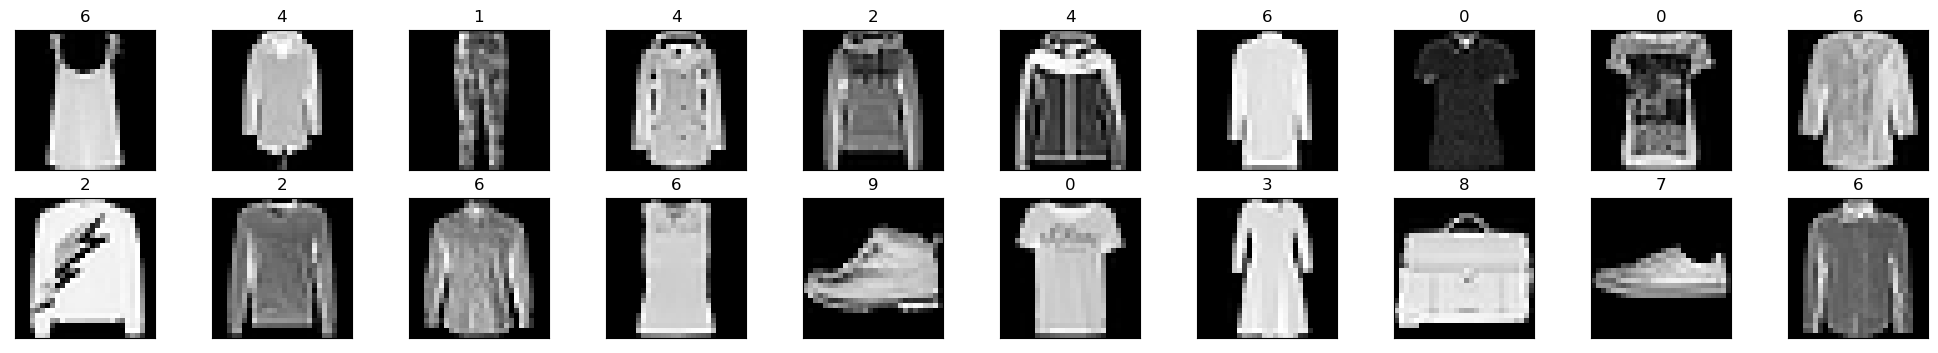

In [ ]:
# CELL TO BE COMPLETED
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_iter = iter(train_loader) 
images, labels = data_iter.next() # obtain one batch from the train set
images = images.numpy()
# plot images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray') # .npsqueeze removes single-dimensional entries from the shape of an array
    ax.set_title(str(labels[idx].item())) # .item() gets the value contained in a Tensor

#### **Question 1.4** - View one of these images with more details by superimposing the greyscale intensity values directly on it. <a class="anchor" id="question_1_4"></a>

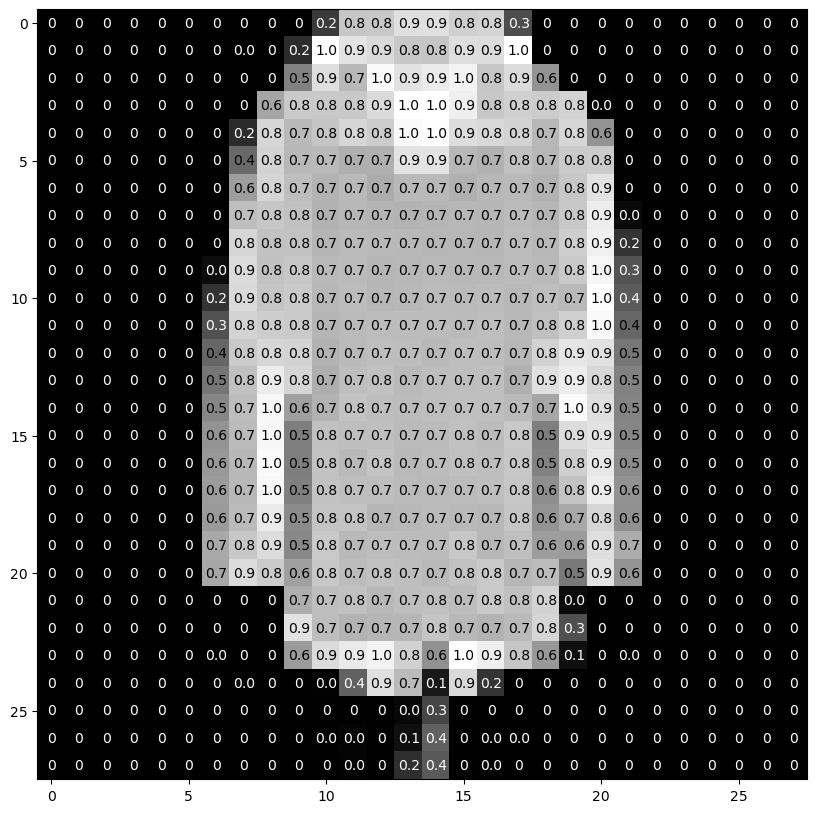

In [ ]:
# CELL TO BE COMPLETED
img = np.squeeze(images[1])
fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],1) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x), horizontalalignment='center', verticalalignment='center', color='white' if img[x][y]<thresh else 'black')

## 2- Multi-Layer Perceptron (MLP) <a class="anchor" id="section_2"></a>

First, let us use a multi-layer perceptron (MLP) to automatically classify Fashion-MNIST images.

#### **Question 2.1** - Define a MPL architecture with (at least) 2 fully-connected as well as dropout layers. <a class="anchor" id="question_2_1"></a>

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module): 
    def __init__(self): # FUNCTION TO BE COMPLETED
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(28*28, 256) # linear layer (784 -> 10)
        self.fc2 = nn.Linear(256, 128) # 
        self.fc3 = nn.Linear(128, 64) # 
        self.fc4 = nn.Linear(64, 10) # 
        self.activate = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
    def forward(self,x): # FUNCTION TO BE COMPLETED
        x = x.view(-1,28*28) # flatten input image
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.activate(x)
        x = self.fc2(x)
        x = self.activate(x)      
        x = self.fc3(x)
        x = self.activate(x)
        x = self.fc4(x)  
        return x

#### **Question 2.2** - Train the pre-defined MPL network with cross entropy as loss function and stochastic gradient descent as optimization algorithm. <a class="anchor" id="question_2_2"></a>

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cuda


In [ ]:
model_1 = MLP()
model_1.to(device=device)

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (activate): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
#DEFINE THE CRITERION
#定义损失，就是和预测结果之间的差异
criterion =  nn.CrossEntropyLoss()       # TO DO

In [ ]:
#DEFINE THE OPTIMIZER 
#优化方法，随机梯度下降，梯度下降绝对收敛
optimizer =  torch.optim.SGD(model_1.parameters(),lr = 0.01)       # TO DO

In [ ]:
n_epochs = 30

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer): # FUNCTION TO BE COMPLETED
  #定义了两个列表，用于存储
  train_losses, valid_losses = [], []
  valid_loss_min = np.Inf

  for epoch in range(n_epochs):
      train_loss, valid_loss = 0, 0
      
      model.train()#意味着模型开始训练了
      for data, label in train_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          optimizer.zero_grad() # clear the gradients of all optimized variables 优化器置0
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model 进行前向传播
          loss = criterion(output, label) # calculate the loss 定义损失
          loss.backward() # backward pass: compute gradient of the loss with respect to model parameters  损失反向传播
          optimizer.step() # perform a single optimization step (parameter update) #更新优化器
          train_loss += loss.item() * data.size(0) # update running training loss  保存每一步损失
           
      model.eval()
      for data, label in valid_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          with torch.no_grad():
              output = model(data)
          loss = criterion(output,label)
          valid_loss += loss.item() * data.size(0)

      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      
      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss
      
  return train_losses, valid_losses      

In [ ]:
#RUN THE TRAINING FUNCTION
train_losses_1, valid_losses_1 = training(n_epochs, train_loader, valid_loader, model_1, criterion, optimizer)

epoch: 1 	training Loss: 1.256659 	validation Loss: 0.715205
validation loss decreased (inf --> 0.715205).  Saving model ...
epoch: 2 	training Loss: 0.656609 	validation Loss: 0.559841
validation loss decreased (0.715205 --> 0.559841).  Saving model ...
epoch: 3 	training Loss: 0.549802 	validation Loss: 0.495741
validation loss decreased (0.559841 --> 0.495741).  Saving model ...
epoch: 4 	training Loss: 0.501156 	validation Loss: 0.461656
validation loss decreased (0.495741 --> 0.461656).  Saving model ...
epoch: 5 	training Loss: 0.470464 	validation Loss: 0.425405
validation loss decreased (0.461656 --> 0.425405).  Saving model ...
epoch: 6 	training Loss: 0.447701 	validation Loss: 0.438786
epoch: 7 	training Loss: 0.428878 	validation Loss: 0.402243
validation loss decreased (0.425405 --> 0.402243).  Saving model ...
epoch: 8 	training Loss: 0.412092 	validation Loss: 0.381209
validation loss decreased (0.402243 --> 0.381209).  Saving model ...
epoch: 9 	training Loss: 0.400839 

#### **Question 2.3** - Plot the evolution of the loss function for both training and validation sets with respect to epochs to study the convergence of the training process. <a class="anchor" id="question_2_3"></a>

Text(0, 0.5, 'loss value')

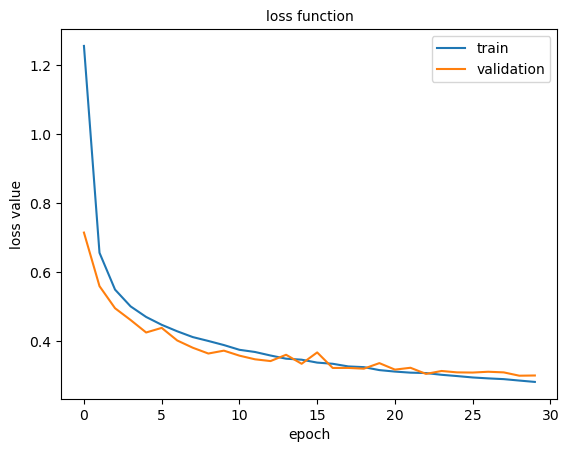

In [ ]:
# CELL TO BE COMPLETED
plt.plot(range(n_epochs), train_losses_1)
plt.plot(range(n_epochs), valid_losses_1)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)

Let us load the model corresponding to the lowest validation loss.

In [ ]:
model_1.load_state_dict(torch.load('model.pt', map_location=device))

<All keys matched successfully>

#### **Question 2.4** - Test the best model on (unseen) test data and evaluate it’s performance in terms of overall and per-class accuracy scores. <a class="anchor" id="question_2_4"></a>

In [ ]:
def evaluation(model, test_loader, criterion): 

  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval()
  for data, label in test_loader:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.long)
      with torch.no_grad():
          output = model(data)
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)
      correct = np.squeeze(pred.eq(label.data.view_as(pred)))
      for i in range(len(label)):
          digit = label.data[i]
          class_correct[digit] += correct[i].item()
          class_total[digit] += 1

  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(10):
      print('test accuracy of %s: %2d%% (%2d/%2d)' % (class_names[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

In [ ]:
#RUN THE EVALUATION FUNCTION
evaluation(model_1, test_loader, criterion) # TO DO

test Loss: 0.328370

test accuracy of T-shirt/top: 84% (840/1000)
test accuracy of Trouser: 96% (969/1000)
test accuracy of Pullover: 79% (798/1000)
test accuracy of Dress: 91% (911/1000)
test accuracy of Coat: 79% (791/1000)
test accuracy of Sandal: 94% (941/1000)
test accuracy of Shirt: 66% (661/1000)
test accuracy of Sneaker: 98% (986/1000)
test accuracy of Bag: 96% (962/1000)
test accuracy of Ankle boot: 93% (930/1000)

test accuracy (overall): 87.89% (8789/10000)


#### **Question 2.5** - Visualize some incorrect predictions by displaying test images and labels in the format: "predicted (ground-truth)". <a class="anchor" id="question_2_5"></a>

In [ ]:
def get_all_prediction(model, loader): 
    preds = torch.tensor([], dtype=torch.long)
    targets = torch.tensor([], dtype=torch.long)
    for data, label in loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        targets = torch.cat((targets, label.cpu()), dim = 0)
        preds = torch.cat((preds, torch.max(output.cpu(), 1)[1]), dim = 0)
    return targets.numpy(), preds.numpy()

In [ ]:
#RUN THE GET_ALL_PREDICTION FUNCTION
targets, preds_1 = get_all_prediction(model_1, test_loader) # TO DO

/tmp/ipykernel_35319/1159938219.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title("{} ({})".format(str(np.int(preds_1[index[i]])), str(np.int(targets[index[i]]))),color=("red"))


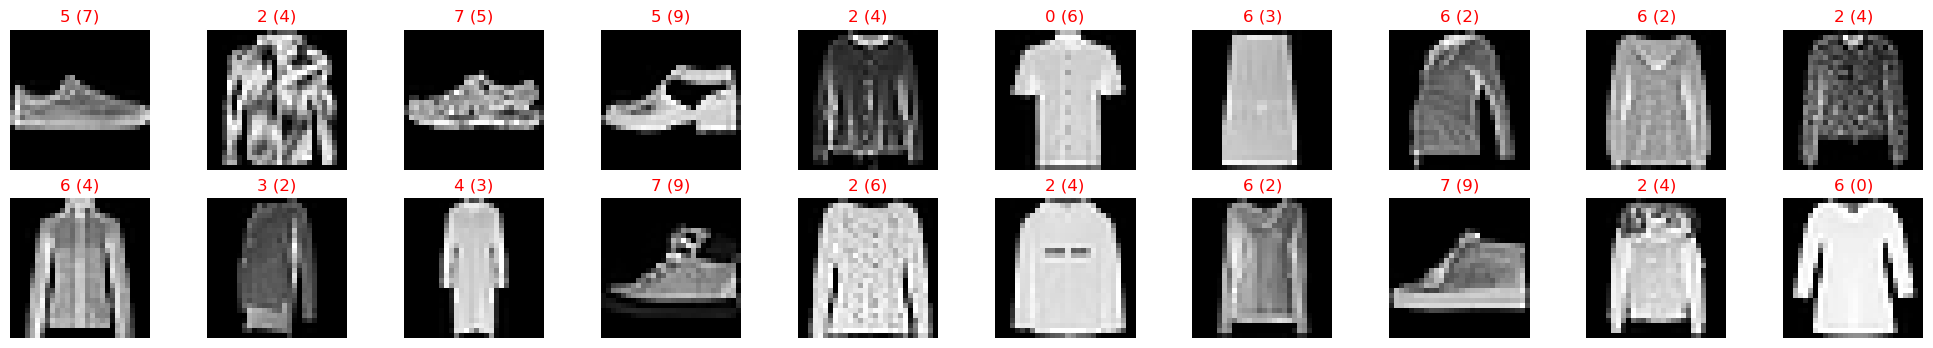

In [ ]:
# CELL TO BE COMPLETED
def visualization(model, test_loader):

  data_iter = iter(test_loader)
  images, labels = data_iter.next() # obtain one batch of test images
  images = images.to(device=device, dtype=torch.float32)
  labels = labels.to(device=device, dtype=torch.long)
  with torch.no_grad():
      output = model(images) # get model output
  _, preds = torch.max(output, 1) # convert output probabilities to predicted class
  images = images.cpu().numpy() # prep images for display
  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(images[idx]), cmap='gray')
      ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

index = np.where(preds_1 - targets != 0)[0]
test_set_array = test_data.data.numpy()
plt.figure(figsize=(25, 4))
for i in range(20):
  plt.subplot(2, 10, i + 1)
  plt.axis('off')
  plt.imshow(test_set_array[index[i],:,:], cmap='gray')
  plt.title("{} ({})".format(str(np.int(preds_1[index[i]])), str(np.int(targets[index[i]]))),color=("red"))
plt.show()

## 3- Convolutional neural network (CNN) <a class="anchor" id="section_3"></a>

Let us now switch from MLP to convolutional neural network (CNN) to classify Fashion-MNIST images.

#### **Question 3.1** - Define a CNN architecture using (at least) 2 patterns [CONV - CONV - POOL] as well as dropout and fully-connected layers. <a class="anchor" id="question_3_1"></a>

In [ ]:
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

class CNN(nn.Module): 

    def __init__(self):
      析构方法
        super(CNN,self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            #卷积层
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            #1是输入通道，4输出通道，核的大小，stride是步长，padding填充
            BatchNorm2d(4),#防止过拟合的正则操作，输出通道是4w
            ReLU(inplace=True),#激活函数
            Conv2d(4, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            #ReLU激活函数，max（0，x）
            #池化层开始了
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )
            #全连接层，
        self.linear_layers = Sequential(
            #这个是输入的大小
            Linear(7 * 7 * 32, 7 * 7 * 8),
            ReLU(inplace=True),
            #这个是输出的大小
            Linear(7 * 7 *8, 10)
        )
        self.dropout = nn.Dropout(p=0.2)

    # Defining the forward pass  
    #前向传播的过程  
    def forward(self, x):
        #扔到卷积层里
        x = self.cnn_layers(x)
        #防止过拟合，随机扔掉一些特征
        x = self.dropout(x)
        #把数据展开，展成一行（为了让他输入全连接层里）
        x = x.view(x.size(0), -1)
        #为了输入的全连接层里
        x = self.linear_layers(x)   
        return x

#### **Question 3.2** - Describe input/output sizes of each layer using summary() from torchsummary. <a class="anchor" id="question_3_2"></a>

In [ ]:
from torchsummary import summary
#实例化
model_2 = CNN()
#模型放入设备
model_2.to(device=device)

# CALL THE SUMMARY FUNCTION TO DISPLAY THE ARCHITECTURE
#展示网络结构
summary(model_2,(1,28,28)) 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 7, 7]            --
|    └─Conv2d: 2-1                       [-1, 4, 28, 28]           40
|    └─BatchNorm2d: 2-2                  [-1, 4, 28, 28]           8
|    └─ReLU: 2-3                         [-1, 4, 28, 28]           --
|    └─Conv2d: 2-4                       [-1, 16, 28, 28]          592
|    └─BatchNorm2d: 2-5                  [-1, 16, 28, 28]          32
|    └─ReLU: 2-6                         [-1, 16, 28, 28]          --
|    └─MaxPool2d: 2-7                    [-1, 16, 14, 14]          --
|    └─Conv2d: 2-8                       [-1, 32, 14, 14]          4,640
|    └─BatchNorm2d: 2-9                  [-1, 32, 14, 14]          64
|    └─ReLU: 2-10                        [-1, 32, 14, 14]          --
|    └─Conv2d: 2-11                      [-1, 32, 14, 14]          9,248
|    └─BatchNorm2d: 2-12                 [-1, 32, 14, 14]          64
|    └─Re

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 7, 7]            --
|    └─Conv2d: 2-1                       [-1, 4, 28, 28]           40
|    └─BatchNorm2d: 2-2                  [-1, 4, 28, 28]           8
|    └─ReLU: 2-3                         [-1, 4, 28, 28]           --
|    └─Conv2d: 2-4                       [-1, 16, 28, 28]          592
|    └─BatchNorm2d: 2-5                  [-1, 16, 28, 28]          32
|    └─ReLU: 2-6                         [-1, 16, 28, 28]          --
|    └─MaxPool2d: 2-7                    [-1, 16, 14, 14]          --
|    └─Conv2d: 2-8                       [-1, 32, 14, 14]          4,640
|    └─BatchNorm2d: 2-9                  [-1, 32, 14, 14]          64
|    └─ReLU: 2-10                        [-1, 32, 14, 14]          --
|    └─Conv2d: 2-11                      [-1, 32, 14, 14]          9,248
|    └─BatchNorm2d: 2-12                 [-1, 32, 14, 14]          64
|    └─Re

#### **Question 3.3** - Train the pre-defined CNN network with cross entropy as loss function and stochastic gradient descent as optimization algorithm. <a class="anchor" id="question_3_3"></a>

In [ ]:
#DEFINE THE OPTIMIZER
optimizer =  torch.optim.SGD(model_2.parameters(),lr = 0.01)       # TO DO

In [ ]:
#RUN THE TRAINING FUNCTION
train_losses_2, valid_losses_2 =  training(n_epochs, train_loader, valid_loader, model_2, criterion, optimizer)# TO DO

epoch: 1 	training Loss: 0.463138 	validation Loss: 0.320424
validation loss decreased (inf --> 0.320424).  Saving model ...
epoch: 2 	training Loss: 0.306066 	validation Loss: 0.275852
validation loss decreased (0.320424 --> 0.275852).  Saving model ...
epoch: 3 	training Loss: 0.262554 	validation Loss: 0.296067
epoch: 4 	training Loss: 0.238197 	validation Loss: 0.248358
validation loss decreased (0.275852 --> 0.248358).  Saving model ...
epoch: 5 	training Loss: 0.220225 	validation Loss: 0.231542
validation loss decreased (0.248358 --> 0.231542).  Saving model ...
epoch: 6 	training Loss: 0.203702 	validation Loss: 0.218917
validation loss decreased (0.231542 --> 0.218917).  Saving model ...
epoch: 7 	training Loss: 0.192277 	validation Loss: 0.219899
epoch: 8 	training Loss: 0.180615 	validation Loss: 0.220496
epoch: 9 	training Loss: 0.171797 	validation Loss: 0.228605
epoch: 10 	training Loss: 0.161896 	validation Loss: 0.213523
validation loss decreased (0.218917 --> 0.213523)

#### **Question 3.4** - Display in a single graph the loss functions for training and validation sets obtained with both MLP and CNN models. <a class="anchor" id="question_3_4"></a>

Text(0, 0.5, 'loss value')

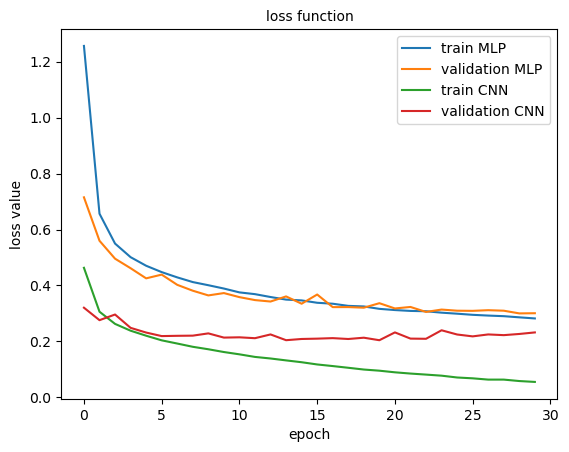

In [ ]:
# CELL TO BE COMPLETED
plt.plot(range(n_epochs), train_losses_1)
plt.plot(range(n_epochs), valid_losses_1)
plt.plot(range(n_epochs), train_losses_2)
plt.plot(range(n_epochs), valid_losses_2)
plt.legend(['train MLP', 'validation MLP', 'train CNN', 'validation CNN'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)

As previously, we load the model corresponding to the lowest validation loss.

In [ ]:
model_2.load_state_dict(torch.load('model.pt', map_location=device))

<All keys matched successfully>

#### **Question 3.5** - Test the model on test data and evaluate it through overall and per-class accuracy scores. Compare these scores with the ones obtained using MLP. <a class="anchor" id="question_3_5"></a>

In [ ]:
#RUN THE EVALUATION FUNCTION
evaluation(model_2, test_loader, criterion) # TO DO

test Loss: 0.220789

test accuracy of T-shirt/top: 89% (895/1000)
test accuracy of Trouser: 97% (979/1000)
test accuracy of Pullover: 89% (890/1000)
test accuracy of Dress: 92% (925/1000)
test accuracy of Coat: 91% (915/1000)
test accuracy of Sandal: 99% (990/1000)
test accuracy of Shirt: 74% (749/1000)
test accuracy of Sneaker: 95% (955/1000)
test accuracy of Bag: 98% (987/1000)
test accuracy of Ankle boot: 97% (976/1000)

test accuracy (overall): 92.61% (9261/10000)


#### **Question 3.6** - Display CNN results for images whose prediction was incorrect with MLP. Labels should be indicated in the following format: "CNN label (ground-truth)" in red if wrong, green otherwise. <a class="anchor" id="question_3_6"></a>

In [ ]:
#RUN THE GET_ALL_PREDICTION FUNCTION
targets, preds_2 = get_all_prediction(model_2, test_loader)# TO DO

/tmp/ipykernel_35319/985825273.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title("{} ({})".format(str(np.int(preds_2[index[i]])), str(np.int(targets[index[i]]))), color=("green" if preds_2[index[i]]==targets[index[i]] else "red"))


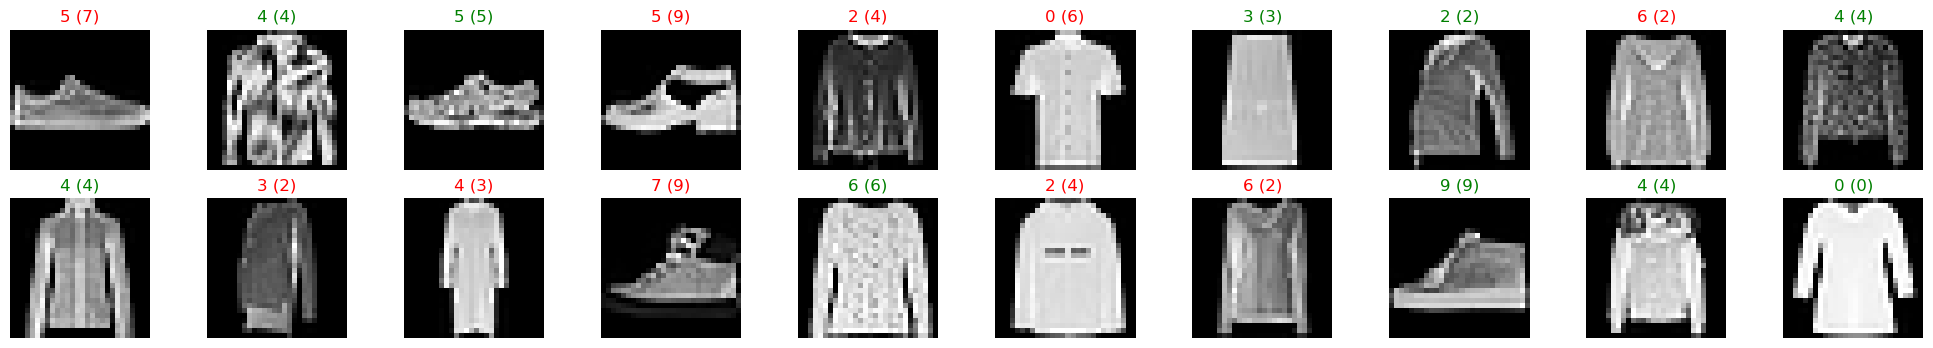

In [ ]:
plt.figure(figsize=(25, 4))
for i in range(20):
  plt.subplot(2, 10, i + 1)
  plt.axis('off')
  plt.imshow(test_set_array[index[i],:,:], cmap='gray')
  plt.title("{} ({})".format(str(np.int(preds_2[index[i]])), str(np.int(targets[index[i]]))), color=("green" if preds_2[index[i]]==targets[index[i]] else "red"))
plt.show()

#### **Question 3.7** - Display the confusion matrix for both MLP and CNN models. <a class="anchor" id="question_3_7"></a>

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    # This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print('confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')

normalized confusion matrix
normalized confusion matrix


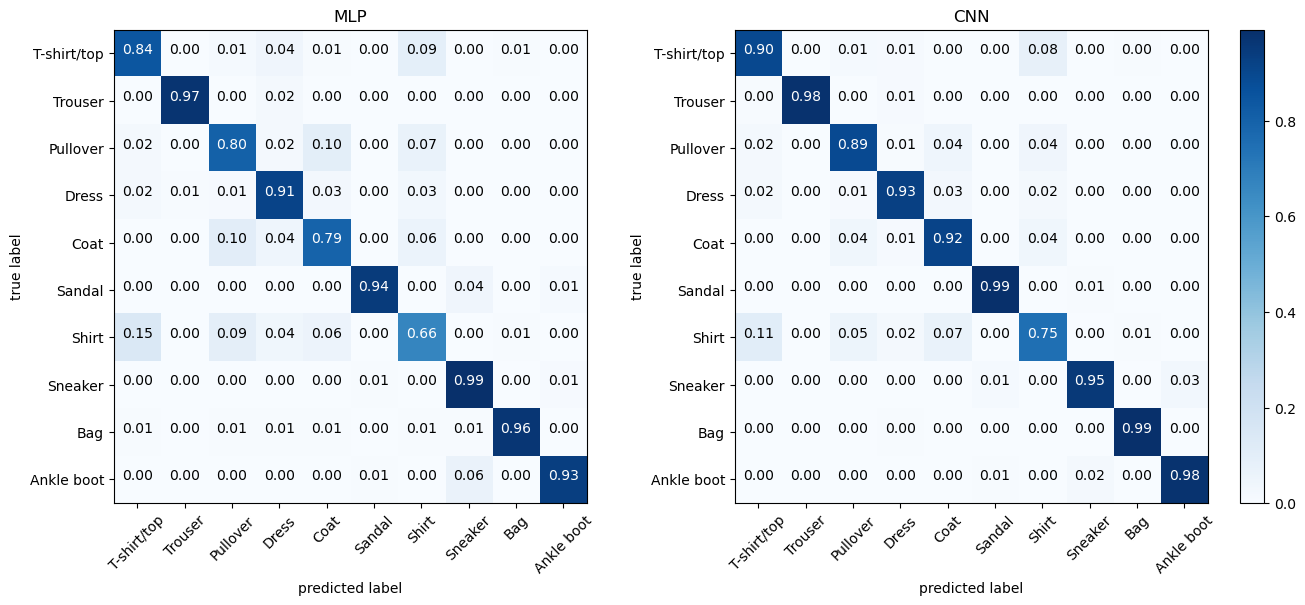

In [ ]:
# CELL TO BE COMPLETED
# compute confusion matrix
cnf_matrix_MLP = confusion_matrix(targets, preds_1)
cnf_matrix_CNN = confusion_matrix(targets, preds_2)
np.set_printoptions(precision=2)

# plot normalized confusion matrixes
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix_MLP, classes=class_names, normalize=True, title='MLP')
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix_CNN, classes=class_names, normalize=True, title='CNN')
plt.show()

## 4- Transfer learning from ImageNet <a class="anchor" id="section_4"></a>

Transfer learning focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.

Our goal is to use a (well-known) CNN architecture whose weights have been already trained on ImageNet to perform transfer learning and fine tuning. ImageNet is a large visual database designed for visual object recognition purposes wich contains more than 14 million images!

#### **Question 4.1** - Modify the Fashion-MNIST dataset to make it fit to  ImageNet by extending Fashion-MNIST images from greyscale to 3-channels images. Since the minimal image dimension as inputs of pre-trained CNN models is 48x48, you will also need to resize images. To do so, use transform.Compose(), transforms.Resize() and transforms.Grayscale(). More details on image transformations are available in the [documentation](https://pytorch.org/vision/stable/transforms.html). <a class="anchor" id="question_4_1"></a>

In [ ]:
#CALL transforms.Compose to adapt the dataset to the VGG16 architecture
transform = transforms.Compose([transforms.Resize([48,48]),transforms.Grayscale(3), transforms.ToTensor(),])# TO DO
#transform = transform.ToTensor()

train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

#### **Question 4.2** - Create training, validation and test data loaders. Check the dimensions of images arising from the modified Fasion-MNIST dataset. <a class="anchor" id="question_4_2"></a>

In [ ]:
# CELL TO BE COMPLETED
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data) # TO DO
data_iter = iter(train_loader)  #TO DO
images, labels = data_iter.next()
print(images.numpy().shape)

(20, 3, 48, 48)


#### **Question 4.3** - Exploit a vgg16 architecture ([related paper](https://arxiv.org/pdf/1409.1556.pdf)) pre-trained on ImageNet to improve the classification scores on Fashion-MNIST through fine-tuning. See the [documentation](https://pytorch.org/vision/stable/models.html#id2) for further details. Use summary() from torchsummary to describe each of the vgg16 layers. To avoid a too long learning time, you may use only 5 epochs during fine-tuning. <a class="anchor" id="question_4_3"></a>

In [ ]:
import torchvision.models as models

model_3 =  models.vgg16(pretrained = True)# TO DO
model_3.to(device=device)
summary(model_3, (3, 48, 48))

/opt/campux/virtualenv/deeplearning-u22/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/campux/virtualenv/deeplearning-u22/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /homes/z21zhan2/.cache/torch/hub/checkpoints/vgg16-397923af.pth
4.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.io

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 48, 48]          1,792
|    └─ReLU: 2-2                         [-1, 64, 48, 48]          --
|    └─Conv2d: 2-3                       [-1, 64, 48, 48]          36,928
|    └─ReLU: 2-4                         [-1, 64, 48, 48]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 24, 24]          --
|    └─Conv2d: 2-6                       [-1, 128, 24, 24]         73,856
|    └─ReLU: 2-7                         [-1, 128, 24, 24]         --
|    └─Conv2d: 2-8                       [-1, 128, 24, 24]         147,584
|    └─ReLU: 2-9                         [-1, 128, 24, 24]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 12, 12]         --
|    └─Conv2d: 2-11                      [-1, 256, 12, 12]         295,168
|    └─ReLU: 2-12                        [-1, 256, 12, 12]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 48, 48]          1,792
|    └─ReLU: 2-2                         [-1, 64, 48, 48]          --
|    └─Conv2d: 2-3                       [-1, 64, 48, 48]          36,928
|    └─ReLU: 2-4                         [-1, 64, 48, 48]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 24, 24]          --
|    └─Conv2d: 2-6                       [-1, 128, 24, 24]         73,856
|    └─ReLU: 2-7                         [-1, 128, 24, 24]         --
|    └─Conv2d: 2-8                       [-1, 128, 24, 24]         147,584
|    └─ReLU: 2-9                         [-1, 128, 24, 24]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 12, 12]         --
|    └─Conv2d: 2-11                      [-1, 256, 12, 12]         295,168
|    └─ReLU: 2-12                        [-1, 256, 12, 12]      

In [ ]:
#DEFINE THE OPTIMIZER
optimizer =  torch.optim.SGD(model_3.parameters(),lr = 0.01)       # TO DO

In [ ]:
n_epochs = 5
#RUN THE TRAINING FUNCTION
train_losses_3, valid_losses_3 =  training(n_epochs, train_loader, valid_loader, model_3, criterion, optimizer)# TO DO   # TO DO

epoch: 1 	training Loss: 0.055003 	validation Loss: 0.219986
validation loss decreased (inf --> 0.219986).  Saving model ...
epoch: 2 	training Loss: 0.047211 	validation Loss: 0.243155
epoch: 3 	training Loss: 0.040168 	validation Loss: 0.284287
epoch: 4 	training Loss: 0.035913 	validation Loss: 0.256462
epoch: 5 	training Loss: 0.028194 	validation Loss: 0.273060


#### **Question 4.4** - Test the model on test data and evaluate it through overall and per-class accuracy scores. Compare these scores with the previously obtained ones. <a class="anchor" id="question_4_4"></a>

In [ ]:
model_3.load_state_dict(torch.load('model.pt', map_location=device))

<All keys matched successfully>

In [ ]:
#RUN THE EVALUATION FUNCTION
evaluation(model_3, test_loader, criterion) # TO DO

test Loss: 0.249574

test accuracy of T-shirt/top: 83% (839/1000)
test accuracy of Trouser: 98% (987/1000)
test accuracy of Pullover: 90% (907/1000)
test accuracy of Dress: 93% (936/1000)
test accuracy of Coat: 91% (918/1000)
test accuracy of Sandal: 98% (989/1000)
test accuracy of Shirt: 82% (829/1000)
test accuracy of Sneaker: 97% (976/1000)
test accuracy of Bag: 99% (998/1000)
test accuracy of Ankle boot: 97% (971/1000)

test accuracy (overall): 93.50% (9350/10000)


#### **Question 4.5** - Display results for images whose prediction was incorrect with MLP. Labels should be indicated in the following format: "vgg16 label (ground-truth)" in red if wrong, green otherwise. <a class="anchor" id="question_4_5"></a>

In [ ]:
#RUN THE GET_ALL_PREDICTION FUNCTION
targets, preds_3 = get_all_prediction(model_3, test_loader)# TO DO   # TO DO

/tmp/ipykernel_35319/3348992775.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title("{} ({})".format(str(np.int(preds_3[index[i]])), str(np.int(targets[index[i]]))), color=("green" if preds_2[index[i]]==targets[index[i]] else "red"))


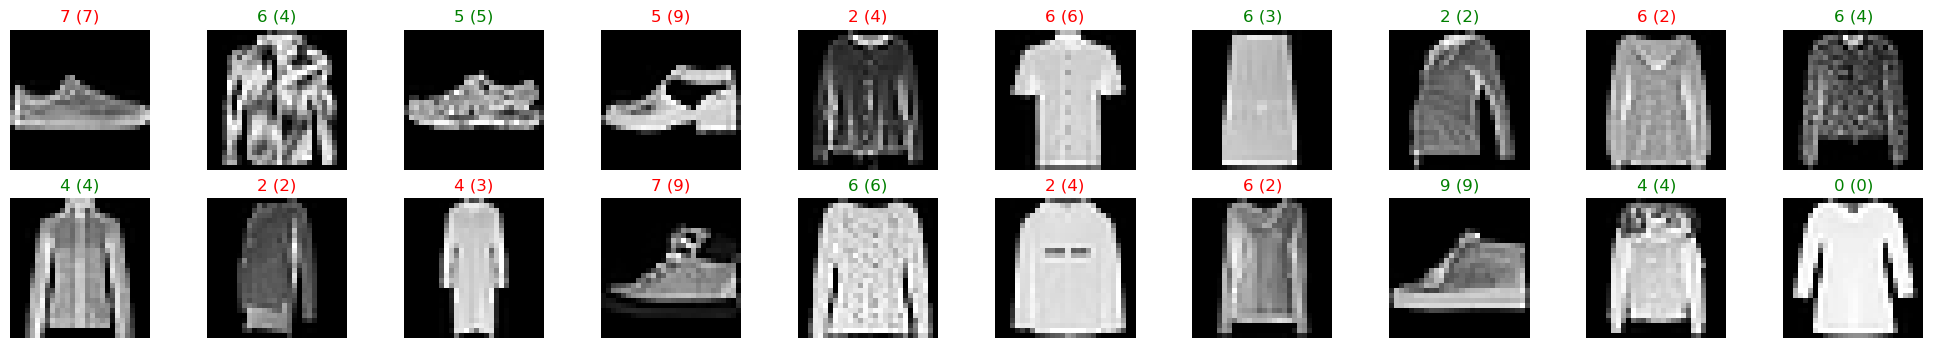

In [ ]:
# CELL TO BE COMPLETED
plt.figure(figsize=(25, 4))
for i in range(20):
  plt.subplot(2, 10, i + 1)
  plt.axis('off')
  plt.imshow(test_set_array[index[i],:,:], cmap='gray')
  plt.title("{} ({})".format(str(np.int(preds_3[index[i]])), str(np.int(targets[index[i]]))), color=("green" if preds_2[index[i]]==targets[index[i]] else "red"))
plt.show()


## 5- Challenge <a class="anchor" id="section_5"></a>

#### **Question 5.1** - What is your best overall test accuracy and with which methodology? The first 3 teams will obtain bonus points! <a class="anchor" id="question_5_1"></a>

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_4 = WideResNet(28, 10, 10, dropRate=0.5)
model_4.to(device)

In [ ]:
optimizer =  torch.optim.Adam(model_1.parameters(),lr = 0.01) 

In [ ]:
n_epochs = 10

In [ ]:
train_losses_4, valid_losses_4 = training(n_epochs, train_loader, valid_loader, model_4, criterion, optimizer)

In [ ]:
evaluation(model_4, test_loader, criterion)